# Line Example

This example shows how to run DiffusionEMD on a line graph and compares it to other methods. 

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import sklearn


from DiffusionEMD import (
    DiffusionCheb,
    DiffusionTree,
)
from DiffusionEMD import dataset
from DiffusionEMD import QuadTree, ClusterTree, MetricTree

### Generate the dataset

Generates `n_points` on a line graph between zero and one. The graph `G` is constructed using a Gaussian kernel of radius `0.1`.

In [2]:
%%time
n_points=100
ds = dataset.Line(n_points=n_points)
G = ds.get_graph()

CPU times: user 20.7 ms, sys: 1.77 ms, total: 22.4 ms
Wall time: 21.2 ms


### Examining DiffusionEMD
The most dataset dependent parameter of DiffusionEMD is the maximum scale parameter. In the paper this is the parameter $K$. This sets the largest diffusion time scale considered. Theory developed in the paper suggests that this must be at least $\left \lceil \log (\text{diameter}(G)) \right \rceil$, and $O(\log n)$ for most graphs. If $K < \left \lceil \log (\text{diameter}(G)) \right \rceil$, then outside a radius of $2^K$ the ground distance reaches a constant maximum value, which may be desirable in some circumstances as the effect of outlier points is limited.

In practice, we find that DiffusionEMD is robust to the choice of scales after a certain level depending on the size of the data. After a certain scale, the differences between the diffused distributions is extremely small, leading to only a rescaling of the DiffusionEMD. This scale can be related to the mixing time of the underlying markov process governed by $P$ over the graph.

Here we take the Diffusion distance of diracs located at each of the 100 points $\delta_x$ to the dirac at 0.5, $\delta_{0.5}$, and plot it against the coordinate $x$. This is zero at $x=0.5$ and increases in both directions.


Embedding Dimensions (100, 600)
CPU times: user 179 ms, sys: 0 ns, total: 179 ms
Wall time: 178 ms


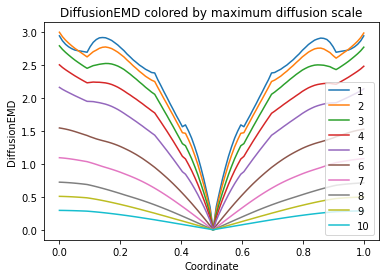

In [3]:
%%time
for max_scale in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dc = DiffusionCheb(max_scale=max_scale)
    embeddings = dc.fit_transform(G.W, ds.labels)
    plt.plot(
        ds.X[:, 0],
        np.sum(np.abs(embeddings - embeddings[n_points//2]), axis=1),
        label=max_scale,
    )
plt.title("DiffusionEMD colored by maximum diffusion scale")
plt.ylabel("DiffusionEMD")
plt.xlabel("Coordinate")
plt.legend(loc=4)
print("Embedding Dimensions", embeddings.shape)

### Reducing the size of the embedding

Notice that in the above example the embedding had dimensions `(100, 600)`, this can be broken down as `(n_distributions, n_points $\times$ n_scales)`, we use a default of `n_scales=6`. This embedding can grow large based on the number of points or the number of distributions so we may want to reduce it. As noted in the paper, larger scales have a very (approximate) rank. We can select a number of points at each scale based on this rank using the parameter $\delta$. This allows us to select a variable number of points at each scale based on the rank of $P^{2^k}$, giving signficiantly reduced embedding sizes, expecially at larger scales. 

Points at each scale: [100, 100, 100, 100, 100, 100] Embedding Size: 600
Points at each scale: [99 97 60 12  8  5] Embedding Size: 281
Points at each scale: [99 92 39  9  7  6] Embedding Size: 252
Points at each scale: [99 77 16  7  6  4] Embedding Size: 209
Points at each scale: [91 38  9  7  6  5] Embedding Size: 156
Points at each scale: [38  9  7  5  4  3] Embedding Size: 66
Points at each scale: [9 7 6 4 4 3] Embedding Size: 33
CPU times: user 3.02 s, sys: 9.32 s, total: 12.3 s
Wall time: 373 ms


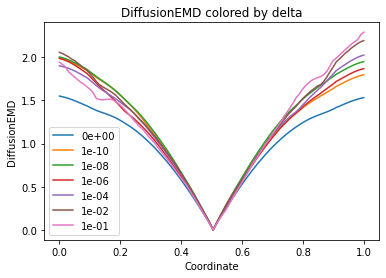

In [4]:
%%time
for delta in [0, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e-1]:
    dc = DiffusionCheb(max_scale=6, delta=delta, min_basis=1)
    embeddings = dc.fit_transform(G.W, ds.labels)
    print("Points at each scale:", dc.basis_sizes, "Embedding Size:", embeddings.shape[1])
    plt.plot(
        ds.X[:, 0],
        np.sum(np.abs(embeddings - embeddings[n_points//2]), axis=1),
        label="%0.0e" % delta,
    )
plt.title("DiffusionEMD colored by delta")
plt.ylabel("DiffusionEMD")
plt.xlabel("Coordinate")
plt.legend()

### Diffusion EMD via Interpolative Decomposition

In practice, when there are many more distributions than there are points, the chebyshev method can scale poorly as it requires $J$ multiplications by the distribution matrix. We can instead directly compute powers of $P^{2^k}$, then multiply by the distributions once. If $m \gg n$ this can be quite a bit faster. We use the `DiffusionTree` class with similar parameters to compute this embedding.

As specified in the paper, this method reduces the size of the basis of $P$ as we go up in powers, this can be unstable, but is much faster than computing high powers of $P$ directly.

CPU times: user 277 ms, sys: 2.72 ms, total: 280 ms
Wall time: 279 ms


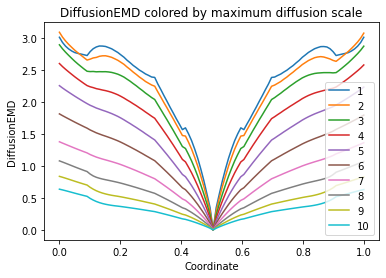

In [5]:
%%time
for max_scale in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    dc = DiffusionTree(max_scale=max_scale)
    
    embeddings = dc.fit_transform(G.W, ds.labels)
    plt.plot(
        ds.X[:, 0],
        np.sum(np.abs(embeddings - embeddings[n_points//2]), axis=1),
        label=max_scale,
    )
plt.title("DiffusionEMD colored by maximum diffusion scale")
plt.ylabel("DiffusionEMD")
plt.xlabel("Coordinate")
plt.legend(loc=4)

Points at each scale: [100 100 100 100 100 100 100] Embedding Size: 700
Points at each scale: [100  99  99  98  61  20  20] Embedding Size: 540
Points at each scale: [99 99 97 61 20 20 20] Embedding Size: 460
Points at each scale: [99 99 92 39 20 20 20] Embedding Size: 456
CPU times: user 423 ms, sys: 859 ms, total: 1.28 s
Wall time: 193 ms


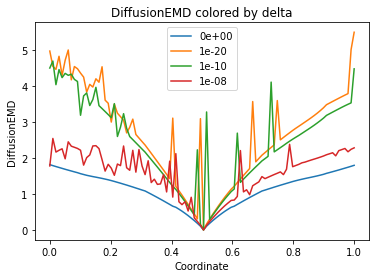

In [6]:
%%time
for delta in [0, 1e-20, 1e-10, 1e-8]:
    dc = DiffusionTree(max_scale=6, delta=delta, min_basis=20)
    embeddings = dc.fit_transform(G.W, ds.labels)
    print("Points at each scale:", dc.basis_sizes, "Embedding Size:", embeddings.shape[1])
    plt.plot(
        ds.X[:, 0],
        np.sum(np.abs(embeddings - embeddings[n_points//2]), axis=1),
        label="%0.0e" % delta,
    )
plt.title("DiffusionEMD colored by delta")
plt.ylabel("DiffusionEMD")
plt.xlabel("Coordinate")
plt.legend()

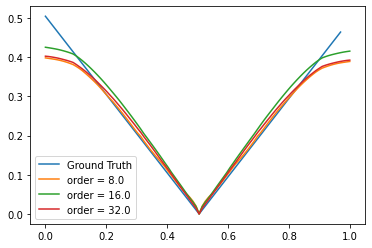

In [7]:
def f(x, ref=0.5, alpha=1):
    return np.sqrt((x - ref) ** 2) ** (2 * alpha)


plt.plot(
    ds.X[:-3, 0],
    f(ds.X[:-3, 0], ref=ds.X[n_points // 2, 0], alpha=0.5),
    label="Ground Truth",
)
for cheb_order in [8, 16, 32]:
    dc = DiffusionCheb(n_scales=5, max_scale=9, cheb_order=cheb_order)
    embeddings = dc.fit_transform(G.W, ds.labels)
    plt.plot(
        ds.X[:, 0],
        np.sum(np.abs(embeddings - embeddings[n_points // 2]), axis=1),
        label="order = %0.1f" % cheb_order,
    )
plt.legend()

### Tree methods

We can also look at other (log) linear time methods for EMD, here we examine two, ClusterTree, built using hierarchical K-means clustering, and QuadTree, built using partitioning of $\mathbb{R}^d$ into grids.

CPU times: user 27.9 s, sys: 1.8 s, total: 29.7 s
Wall time: 28.1 s


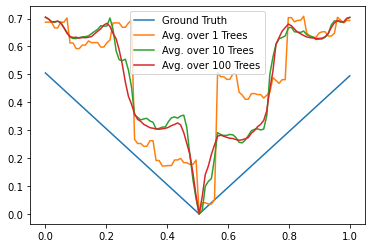

In [8]:
%%time
def l1_embeddings(cts, edge_weights):
    return np.array(
        [np.asarray(cts)[i, :] * np.asarray(edge_weights) for i in range(len(cts))]
    )
tree_dist_list = []
for i in range(100):
    mt = MetricTree(tree_type="cluster", n_clusters=4, n_levels=4)
    counts, edge_weights = mt.fit_transform(
        X=ds.X[:], y=ds.labels
    )
    embeddings_cluster = l1_embeddings(counts.todense(), edge_weights.squeeze())
    tree_dists = sklearn.metrics.pairwise_distances(embeddings_cluster, metric="l1", n_jobs=-1)
    tree_dist_list.append(tree_dists[n_points // 2])

plt.plot(
    ds.X[:, 0],
    f(ds.X[:, 0], ref=ds.X[n_points // 2, 0], alpha=0.5),
    label="Ground Truth",
)
tree_dist_list = np.array(tree_dist_list)
for i in [1, 10, 100]:
    plt.plot(
        ds.X[:, 0], tree_dist_list[:i].mean(axis=0), label="Avg. over %d Trees" % i,
    )

plt.legend(fontsize=10)

CPU times: user 8.26 s, sys: 1.91 s, total: 10.2 s
Wall time: 8.31 s


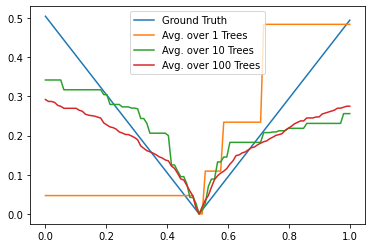

In [9]:
%%time
quadtree_dist_list = []
for i in range(100):
    mt = MetricTree(tree_type="quad", n_levels=6)
    counts, edge_weights = mt.fit_transform(X=ds.X, y=ds.labels)
    embeddings_cluster = l1_embeddings(counts.todense(), edge_weights)
    tree_dists = sklearn.metrics.pairwise_distances(
        embeddings_cluster, metric="l1", n_jobs=-1
    )
    quadtree_dist_list.append(tree_dists[n_points // 2])
quadtree_dist_list = np.array(quadtree_dist_list)

plt.plot(
    ds.X[:, 0],
    f(ds.X[:, 0], ref=ds.X[n_points // 2, 0], alpha=0.5),
    label="Ground Truth",
)
quadtree_dist_list = np.array(quadtree_dist_list)
for i in [1, 10, 100]:
    plt.plot(
        ds.X[:, 0], quadtree_dist_list[:i].mean(axis=0), label="Avg. over %d Trees" % i,
    )

plt.legend(fontsize=10)